In [2]:
def gramarCheck(Sans1,num_words,ans_length):
    import requests
    req = requests.get("https://api.textgears.com/check.php?text=" + Sans1+ "&key=JmcxHCCPZ7jfXLF6")
    no_of_errors = len(req.json()['errors'])
    count_spelling=0
    count_grammar=0
    for item in req.json()['errors']:
            if item['type'] == 'spelling':
                count_spelling+=1
            if item['type'] == 'grammar':
                count_grammar+=1
    error_rate1=count_grammar/ans_length
    error_rate2=count_spelling/num_words
    import math
    percentage_of_error=int(math.sqrt(error_rate1)+math.sqrt(error_rate2)*10)
    return percentage_of_error  

In [3]:
def ocr_to_extract(img_path):
    from azure.cognitiveservices.vision.computervision import ComputerVisionClient
    from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
    from msrest.authentication import CognitiveServicesCredentials
    
    import os
    import time
    import os
    import time
    import json
    
    '''
    Authenticate
    Authenticates your credentials and creates a client.
    '''
    subscription_key = os.environ["VISION_KEY"]
    endpoint = os.environ["VISION_ENDPOINT"]
    
    computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))
    '''
    END - Authenticate
    '''
    
    '''
    OCR: Read File using the Read API, extract text - local
    This example will extract text in an image, then print results, line by line.
    This API call can also extract handwriting style text (not shown).
    '''
    
    # Open local image file
    local_image_path = img_path  # Change this to the path of your local image
    local_image = open(local_image_path, "rb")
    
    # Call API with local image
    read_response = computervision_client.read_in_stream(local_image, raw=True)
    
    # Get the operation location (URL with an ID at the end) from the response
    read_operation_location = read_response.headers["Operation-Location"]
    # Grab the ID from the URL
    operation_id = read_operation_location.split("/")[-1]
    
    # Call the "GET" API and wait for it to retrieve the results
    while True:
        read_result = computervision_client.get_read_result(operation_id)
        if read_result.status not in ['notStarted', 'running']:
            break
        time.sleep(1)
    
    # Print the detected text, line by line
    # if read_result.status == OperationStatusCodes.succeeded:
        
    #     for text_result in read_result.analyze_result.read_results:
    #         print( text_result)
    #         for line in text_result.lines:
    #             print(line.text)
    # print()
    # '''
    # END - Read File - local
    # '''
    
    # print("End of Computer Vision quickstart.")
    result_json = {
        "modelVersion": "2024-02-01",
        "metadata": {
            "width": None,
            "height": None
        },
        "readResult": {
            "lines": []
        }
    }
    
    # Print the detected text, line by line
    if read_result.status == OperationStatusCodes.succeeded:
        for text_result in read_result.analyze_result.read_results:
            result_json["metadata"]["width"] = text_result.width
            result_json["metadata"]["height"] = text_result.height
            for line in text_result.lines:
                line_info = {
                    "text": line.text,
                    "boundingPolygon": [
                        {"x": line.bounding_box[i], "y": line.bounding_box[i+1]} for i in range(0, len(line.bounding_box), 2)
                    ],
                    "words": [
                        {
                            "text": word.text,
                            "boundingPolygon": [
                                {"x": word.bounding_box[i], "y": word.bounding_box[i+1]} for i in range(0, len(word.bounding_box), 2)
                            ],
                            "confidence": word.confidence
                        } for word in line.words
                    ]
                }
                result_json["readResult"]["lines"].append(line_info)
    
    # Print the resulting JSON
    return [result_json["readResult"]]
    

In [4]:
def extract_texts_from_answerpaper(folder):
    import os
    from PIL import Image
    files = os.listdir(folder)

# Filter and sort the files
# This assumes the files are named in the format 'answer_paper1', 'answer_paper2', etc.
    image_files = sorted(
     [f for f in files if f.startswith('ans_paper') and f.endswith(('.png', '.jpg', '.jpeg'))],
     key=lambda x: int(x[len('ans_paper'):-4])
    )
    x=list()
# Process each image file
    for image_file in image_files:
        image_path = os.path.join(folder, image_file)
        x.append(ocr_to_extract(image_path))
    return x

In [5]:
def preprocessTheSentence(stmt1):
    stmt1=stmt1.lower()
    #step1:Removing punctuations
    import string
    remove=dict.fromkeys(map(ord,'\n'+string.punctuation)," ")
    PSA1=stmt1.translate(remove)
    #step2:Removing stop words
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize 
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(PSA1) 
    PSA2 = [w for w in word_tokens if not w in stop_words]
    #step3:Removing prepositions
    import nltk
    a=list()
    b=list()
    PSA3=" "
    for i in range(len(PSA2)):
        a=list(nltk.pos_tag([PSA2[i]]))
        if a[0][1]!='IN':
            b.append(PSA2[i])
        PSA3=" ".join(b)
    return PSA3

In [6]:
def matchAnswersWithKeyAnswer(Sans1,Kans1):
    from nltk.tokenize import sent_tokenize
    stmts=sent_tokenize(Sans1)
    answer=""
    for i in range(len(stmts)):
        answer+=preprocessTheSentence(stmts[i])+'\n'
    stmts=sent_tokenize(Kans1)
    KEY=""
    for i in range(len(stmts)):
        KEY+=preprocessTheSentence(stmts[i])+'\n'
    def synkey(w):
        a3=list(set(word_tokenize(answer)))
        import nltk 
        from nltk.corpus import wordnet 
        synonyms = set()
        for syn in wordnet.synsets(w): 
            for l in syn.lemmas(): 
                synonyms.add(l.name()) 
        synonyms=list(synonyms)
        for i in range(len(synonyms)):
            if synonyms[i] in a3:
                return True
        return False
    from nltk.tokenize import word_tokenize
    a1=KEY.split('\n')
    a1.remove(a1[-1])
    count1=len(a1)
    for i in range(len(a1)):
        str2find=a1[i]
        m=answer.find(str2find)
        if m==-1:
            count1-=1
    count1=(count1/len(a1))*100
    a2=list(set(word_tokenize(KEY)))
    a3=list(set(word_tokenize(answer)))
    count2=0
    for i in range(len(a2)):
        if a2[i] in a3:
            count2+=1
        else:
            cndtn=synkey(a2[i])
            if cndtn:
                count2+=1
    count2=(count2/len(a2))*100     
    if count1>=count2:
        keyMatchRatio=count1
    else:
        keyMatchRatio=count2
    return keyMatchRatio 

In [7]:
def ansLen(num_words,ans_length,ans_weightage):
    if num_words > 25*ans_weightage:
        marks=10
    elif num_words >23*ans_weightage and num_words <25*ans_weightage:
        marks=9
    elif num_words > 20*ans_weightage and num_words <23*ans_weightage:
        marks=8
    elif num_words >18*ans_weightage and num_words < 20*ans_weightage:
        marks=7
    elif num_words > 16*ans_weightage and num_words < 18*ans_weightage:
        marks=6
    elif num_words > 14*ans_weightage and num_words< 16*ans_weightage:
        marks=5
    elif num_words >11*ans_weightage and num_words <14*ans_weightage:
        marks=4
    elif num_words > 8*ans_weightage and num_words<11*ans_weightage:
        marks=3
    elif num_words>4*ans_weightage and num_words<8*ans_weightage:
        marks=2
    elif num_words >3*ans_weightage and num_words<4*ans_weightage:
        marks=1
    else:
        marks=0
    if ans_length >=2.5*ans_weightage:
        m=10
    elif ans_length>=2*ans_weightage and ans_length<2.5*ans_weightage:
        m=8
    elif ans_length>=1.5*ans_weightage and ans_length<2*ans_weightage:
        m=6
    elif ans_length>=1.0*ans_weightage and ans_length<1.5*ans_weightage:
        m=4
    elif ans_length>1.0 and ans_length<0.5*ans_weightage:
        m=2
    else:
        m=0
    total_marks_of_student=(marks+m)/2
    return int(total_marks_of_student)

In [8]:
def marks_for_each_question(answer_length_check_creteria,grammer_check_creteria,key_word_match_creteria,max_marks):
    fetch_marks=max_marks
    ans_length_weight=4.0
    if answer_length_check_creteria>6 and answer_length_check_creteria<=7.5:
        ans_length_weight=(90*ans_length_weight)/100
    elif answer_length_check_creteria>5 and answer_length_check_creteria<=6:
        ans_length_weight=(80*ans_length_weight)/100
    elif answer_length_check_creteria>4 and answer_length_check_creteria<=5:
        ans_length_weight=(70*ans_length_weight)/100
    elif answer_length_check_creteria>3 and answer_length_check_creteria<=4:
        ans_length_weight=(50*ans_length_weight)/100
    elif answer_length_check_creteria>2 and answer_length_check_creteria<=3:
        ans_length_weight=(30*ans_length_weight)/100
    elif answer_length_check_creteria>0 and answer_length_check_creteria<=2:
        ans_length_weight=(5*ans_length_weight)/100
    
    answer_length_check_total=(fetch_marks*ans_length_weight)/10
    
    grammer_weight=1.0
    if grammer_check_creteria>=1 and grammer_check_creteria<=3:
        grammer_weight=1
    elif grammer_check_creteria>=4 and grammer_check_creteria<=6:
        grammer_weight=(70*grammer_weight)/100
    elif grammer_check_creteria>=7 and grammer_check_creteria<=10:
        grammer_weight=(40*grammer_weight)/100
    elif grammer_check_creteria>10:
        grammer_weight=0
    
    grammer_check_total=(fetch_marks*grammer_weight)/10
    
    keyword_match_weight=5
    if key_word_match_creteria<10:
        keyword_match_weight=0.4
    elif key_word_match_creteria>=10 and key_word_match_creteria<=19:
        keyword_match_weight=(20*keyword_match_weight)/100
    elif key_word_match_creteria>=20 and key_word_match_creteria<=29:
        keyword_match_weight=(30*keyword_match_weight)/100
    elif key_word_match_creteria>=30 and key_word_match_creteria<=39:
        keyword_match_weight=(40*keyword_match_weight)/100
    elif key_word_match_creteria>=40 and key_word_match_creteria<=49:
        keyword_match_weight=(50*keyword_match_weight)/100
    elif key_word_match_creteria>=50 and key_word_match_creteria<=59:
        keyword_match_weight=(60*keyword_match_weight)/100
    elif key_word_match_creteria>=60 and key_word_match_creteria<=69:
        keyword_match_weight=(70*keyword_match_weight)/100    
    elif key_word_match_creteria>=70 and key_word_match_creteria<=79:
        keyword_match_weight=(80*keyword_match_weight)/100
    elif key_word_match_creteria>=80 and key_word_match_creteria<=89:
        keyword_match_weight=(90*keyword_match_weight)/100
    elif key_word_match_creteria>=90:
        keyword_match_weight=5
        
    key_word_match_total=(fetch_marks*keyword_match_weight)/10  
    
    
    import math
    t=round(answer_length_check_total+grammer_check_total+key_word_match_total)
    print("answer length check ",answer_length_check_total)
    print(grammer_check_total)
    print(key_word_match_total)
    data=[t,grammer_check_total,answer_length_check_total,key_word_match_total]
    return data;

In [9]:
def evaluate_marks_a_question(Sans,Kans,num_words,ans_length,ans_type,weightage):
    if(Sans == " "):
        return [0,0,0,0]
    if(ans_type.lower()=="short"):
        marks_obtained=evaluate_one_word(Sans,Kans);
        print("marks obtained for       ",weightage,"   is   ",marks_obtained)
        return [marks_obtained,0,0,0];
    elif(ans_type.lower()=="discriptive"):
     answer_length_check_creteria=ansLen(num_words,ans_length,weightage)
     answer_length_check_creteria=float(answer_length_check_creteria)
     grammer_check_creteria=gramarCheck(Sans,num_words,ans_length)
     grammer_check_creteria=float(grammer_check_creteria)
     key_word_match_creteria=matchAnswersWithKeyAnswer(Sans,Kans)
     key_word_match_creteria=float(key_word_match_creteria)
     marks_obtained=marks_for_each_question(answer_length_check_creteria,grammer_check_creteria,key_word_match_creteria,weightage)
     import math
     marks_obtain=round(marks_obtained[0])
     print("marks obtained for       ",weightage,"   is   ",marks_obtain)
     return marks_obtained;
    elif(ans_type.lower()=="tof"):
        marks_obtained=evaluate_tof(Sans,Kans);
        print("marks obtained for       ",weightage,"   is   ",marks_obtained)
        return [marks_obtained,0,0,0];

In [10]:
def evaluate_one_word(Sans,Kans):
    
    from nltk.tokenize import sent_tokenize
    stmts=sent_tokenize(Sans)
    answer=""
    for i in range(len(stmts)):
        answer+=preprocessTheSentence(stmts[i])+'\n'
    KEY=Kans
    def synkey(w):
        a3=list(set(word_tokenize(answer)))
        import nltk 
        from nltk.corpus import wordnet 
        synonyms = set()
        for syn in wordnet.synsets(w): 
            for l in syn.lemmas(): 
                synonyms.add(l.name()) 
        synonyms=list(synonyms)
        for i in range(len(synonyms)):
            if synonyms[i] in a3:
                return True
        return False
    from nltk.tokenize import word_tokenize
    a2=list(set(word_tokenize(KEY)))
    a3=list(set(word_tokenize(answer)))
    count2=0
    for i in range(len(a2)):
        if a2[i] in a3:
            count2+=1
        else:
            cndtn=synkey(a2[i])
            if cndtn:
                count2+=1   
    if count2>0:
        return 1;
    return 0;


In [14]:
def evaluate_tof(Sans,Kans):
    import re
    true_pattern = r'true'
    false_pattern = r'false'
    
    if re.search(true_pattern, Sans, re.IGNORECASE) and re.search(false_pattern, Sans, re.IGNORECASE):
        return 0

    if(Kans.lower()=="true"):
        pattern = r'\b\s*[Tt][Rr][Uu][Ee]\s*\b|\b\s*[Tt]\s*\b'
        if re.search(pattern, Sans, re.IGNORECASE):
            return 1
        return 0
    else:
          if re.search(r'false|falge|fals|palse|pals|s*[Ff]\s*', Sans, re.IGNORECASE):
            return 1
          else:
            return 0
        
    

In [18]:
evaluate_tof("TRUE","TRUE")

1

In [19]:
def segment_answers(answers_json):
    answers=list()
    data={"qno":"","ans":"","no_of_lines":0,"diagram":0,"diagram_path":0}
    ans = " "
    qno=""
    no_of_lines=0
    starting_cords=0
    ending_cords=0
    page_no=0
    for x in answers_json :
            
            page_no+=1
            if(len(x)!=0):
                for items in x[0]["lines"] :
                   
                
                    if  items["boundingPolygon"][3]["y"]>150:
                        if  items["boundingPolygon"][3]["x"]<150 and check_answerlabel(items["text"])  :
                            data["ans"]=ans
                            data["no_of_lines"]=no_of_lines
                            ending_cords=((page_no-1)*1300+items["boundingPolygon"][3]["y"])
                            if no_of_lines > 0 :
                                if(qno==""):
                                    try:
                                        answers[-1].ans= answers[-1].ans+" "+ans
                                        answers[-1].no_of_lines= answers[-1].no_of_lines+" "+no_of_lines
                                    except IndexError as e:
                                        print(f"Error: {e}. Index  is out of range for the list.")
                                else : 
                                    number_of_spaces = ans.count(' ') 
                                    
                                    answers.append({"qno":qno,"page_no":page_no1,"ans":ans,"no_of_lines": no_of_lines,"no_of_words":number_of_spaces,"diagram_marks":0,"diagram_path":0,"starting_cords": starting_cords,"ending_cords":ending_cords,})
                                    
                            qno=remove_extra_chars(items["text"])
                            starting_cords= ending_cords=((page_no-1)*1300+items["boundingPolygon"][3]["y"])
                            ans=" "
                            no_of_lines=0
                            page_no1=page_no
                        
                        else :
                            ans=ans+items["text"]+" "
                            no_of_lines+=1
                            
                        
                        
    number_of_spaces = ans.count(' ')                    
    answers.append({"qno":qno,"page_no":page_no,"ans":ans,"no_of_lines": no_of_lines,"no_of_words":number_of_spaces,"diagram_marks":0,"diagram_path":0,"starting_cords": starting_cords,"ending_cords":ending_cords}) 
    # print("end")
    # print(answers)
    return answers
    # print(answers)


In [20]:

def check_answerlabel(str):
    import re
    no_spaces = str.replace(" ", "")
    pattern = r"^(.*?)([aA][nN][sS]|[aA][nN][sS][wW][eE][rR]|[aA][nN]|[aA][nN][gG])[,\.]?(\d+)[a-zA-Z,\.]*[\(\)\[\]\{\}]*$"
    return bool(re.match(pattern, no_spaces))


In [21]:
def generate_stud_answer_csv(answers,folderpath):
    import csv
     
    header = ["qno","page number","answer","no_of_lines","no_of_words","diagram_marks","diagram_path","starting_cords","ending_cords","diagram_cords","diagram_page"];
    with open(folderpath+'/student_answer.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)
        for ans in answers :
            data=[ans['qno'],ans['page_no'],ans['ans'],ans['no_of_lines'],ans['no_of_words'],ans['diagram_marks'],ans['diagram_path'],ans['starting_cords'],ans['ending_cords'],0,0];
            writer.writerow(data)


    print("CSV file has been generated.")

In [22]:
# generate_stud_answer_csv(ans)

In [23]:
def remove_extra_chars(s):
    import re
    # Pattern to match and capture the number and characters after it
    cleaned_string = re.sub(r"[<>,\.\(\)\[\]\{\}]", "", s)
    # Remove characters before the first number
    cleaned_string = re.sub(r"^[^\d]*", "", cleaned_string)
    return cleaned_string

In [24]:
def evaluation(folder,extracted_answer):
    import pandas as pd
    try:
        # Read student answers and schema DataFrames
        student_ans = pd.read_csv(folder+"/student_answer.csv")
        schema_ans = pd.read_csv("Schema/Schema.csv")
        marks_info=[];

        for index, row in student_ans.iterrows():
            expected_ans_row = schema_ans.loc[schema_ans['qno'] == row['qno']]
            if expected_ans_row.empty:
                print(f"Warning: No expected answer found for question {row['qno']}.")
                continue
            
            no_of_lines = int(row['no_of_lines'])
            answer_type = expected_ans_row['answer_type'].values[0]
            marks = int(expected_ans_row['marks'].values[0])
            key_answer=str(expected_ans_row['answer'].values[0])
            no_of_words=  int(row['no_of_words'])
            data=[str(expected_ans_row['qno'].values[0]),answer_type,marks]
            # print(data+evaluate_marks_a_question(row['answer'],key_answer,100,int(no_of_lines), str(answer_type),marks))
            if(expected_ans_row["diagram"].values[0]=="yes"):
                data.extend(evaluate_marks_a_question(row['answer'],key_answer,no_of_words,int(no_of_lines), str(answer_type),marks-expected_ans_row["diagram marks"].values[0]))
            else:
                data.extend(evaluate_marks_a_question(row['answer'],key_answer,no_of_words,int(no_of_lines), str(answer_type),marks))

            data.extend([0,0])
            if(expected_ans_row["diagram"].values[0]=="yes"):
                paths=row['diagram_path']
                separated_paths = paths.split('|')
                diagram_cords = row['diagram_cords'].split(',')
                for path in separated_paths:
                  if path:
                    d_marks=evaluate_diagrams(row['diagram_page'],path,expected_ans_row["diagram_path"].values[0],diagram_cords,extracted_answer)
                    data[7]=1
                    # reduce_ratio=(marks-expected_ans_row["diagram marks"].values[0])/marks
                    data[8]=d_marks*expected_ans_row["diagram marks"].values[0]
                    # data[3]=data[3]*reduce_ratio
                    # data[4]=data[4]*reduce_ratio
                    # data[5]=data[5]*reduce_ratio
                    # data[6]=data[6]*reduce_ratio
                      
                    
            marks_info.append(data);
            # Print separator
            print("**************************************")
        print_on_markscard(marks_info,folder)

    

      

    except FileNotFoundError as e:
        print(f"Error: File not found - {e}")
    except (KeyError, ValueError) as e:
        print(f"Error: Data type mismatch or missing data - {e}")




In [25]:
def print_on_markscard(marks_info,folder):
    import csv
    header = ["qno","answer type","max marks","diagram","grammer mrks obtained","ans lenght mrks obtained","keyword match mrks obtained","diagram mrks obtained","marks obtained"];
    with open((folder+'/student_markscard.csv'), 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)
        for marks in marks_info :
                data=[marks[0],marks[1],marks[2],marks[7],marks[4],marks[5],marks[6],marks[8],round(marks[3]+marks[8])]
                print(data)
                writer.writerow(data)
    print("CSV file has been generated.")
    

In [26]:
def cropout_diagram(img_path,model,page_no,folder):
    import pandas as pd
    import matplotlib.pyplot as plt
    student_ans_csv=pd.read_csv(folder+'/student_answer.csv')
    filtered_df = student_ans_csv[student_ans_csv['page number'] == page_no]
    from PIL import Image
    import os
    results=model.predict(img_path)
    result=results[0]
    Image.fromarray(result.plot()[:,:,::-1])
    img = Image.open(img_path)
    max=-1
    final_cords=0
    count=1;
    for box in result.boxes :
         cords = box.xyxy[0].tolist()
         class_id = box.cls[0].item()
         conf = box.conf[0].item()
         if(class_id == 0.0):
             img2 = img.crop(cords)
             plt.imshow(img2)
             plt.axis('off')
             plt.show()
             new_filtered = filtered_df[(filtered_df['starting_cords'] <= ((page_no-1)*1300+cords[1]+100)) & (filtered_df['ending_cords'] >= ((page_no-1)*1300+cords[3]-100))]
             if not new_filtered.empty:
              
                 question_no=new_filtered["qno"].values[0]
                 user_input = input("is diagram cropped properly and belong  y or n: ")
                 if(user_input=="y"):
                     prev_data=str(new_filtered['diagram_path'].values[0])
                     if(prev_data=='0'):
                         prev_data=""
                    
                    
                     
                     base_name, ext = os.path.basename(img_path).rsplit('.', 1)
                     new_filename = f"{base_name}_cropped_{count}.{ext}"
                     # path=os.path.join(folder+"/diagram", new_filename);
                     path=folder+"/diagram/"+new_filename;
                     prev_data=prev_data +path+"|"
                     
                     row_index = student_ans_csv.index[student_ans_csv["qno"] == question_no].tolist()
                     student_ans_csv['diagram_cords'] = student_ans_csv['diagram_cords'].astype(str)
                    # Update the specific column with the new data
                     if len(row_index) > 0:
                        cords = [round(num) for num in cords]
                        print(','.join(map(str, cords)))
                        student_ans_csv['diagram_cords'] = student_ans_csv['diagram_cords'].astype(str)
                        student_ans_csv.iloc[row_index[0], 9] = ','.join(map(str, cords))
                        student_ans_csv.iloc[row_index[0], 10] = page_no
                       
                        student_ans_csv.iloc[row_index[0], 6] = str(prev_data)
                        student_ans_csv['diagram_path'] = student_ans_csv['diagram_path'].astype(str)
                    
                    # Write the updated data back to the CSV file
                     student_ans_csv.to_csv(folder+'/student_answer.csv', index=False)
                     img2.save(path)
                     count=count+1


In [27]:
def extract_diagram(folder):
    # !pip install --upgrade ultralytics
    from ultralytics import YOLO
    yolomodel = YOLO('runs/detect/train132/weights/best.pt')
    import pandas as pd
    import os 
    from PIL import Image
    import matplotlib.pyplot as plt
    
    # Define the folder containing the images
    input_folder = folder
    
    # Get a list of all image files in the input folder
    image_files = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]
    
    # Sort the image files if necessary
    image_files.sort()
    
    # Loop through the files and display them with new filenames
    for idx, image_file in enumerate(image_files, start=1):
        if(image_file !="student_answer.csv"):
            if(image_file !="student_markscard.csv"):
                img = Image.open((input_folder+"/"+image_file))
                new_filename = f'ans_paper{idx}.jpg'
                os.path.join(input_folder, image_file)
                
                cropout_diagram((input_folder+"/"+image_file),yolomodel,idx,folder)
            
                # Display the image with the new filename
                plt.imshow(img)
                
                plt.title(new_filename)
                plt.axis('off')
                plt.show()
    
    print("All images have been processed.")
    

In [28]:
# extract_diagram()

In [29]:
def evaluate_diagrams(page_no,sans_path,kans_path,cords,x):
    import cv2
    score_for_diagram=0
    score_for_label=0
# Paths to the images to be compared
    image_path1 = sans_path
    image_path2 = kans_path
    # Load the images
    image1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)
    
    # Initialize the ORB detector
    orb = cv2.ORB_create()
    
    # Detect keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(image1, None)
    kp2, des2 = orb.detectAndCompute(image2, None)
    
    # Use BFMatcher to find matches between descriptors
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    
    # Sort matches by distance (the lower, the better)
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Calculate the match score
    match_score = sum([match.distance for match in matches]) / len(matches)
    
    # Set a threshold to determine if the images are the same or different
    threshold = 60  # You can adjust this threshold based on your needs
    
    print(f"Match Score: {match_score}")
    if match_score < threshold:
        score_for_diagram=10
    ocr_json=x[page_no-1]
    sans_labels=ocr_to_extract(sans_path)
    kans_labels=ocr_to_extract(kans_path)
    sans_diagram_label=list()
    kans_diagram_label=list()
    for items in sans_labels[0]["lines"] :
         sans_diagram_label.append(items["text"].lower())

    for items in kans_labels[0]["lines"]:
         kans_diagram_label.append(items["text"].lower())
    print( kans_diagram_label, sans_diagram_label)
    common_elements = [element for element in kans_diagram_label if element in sans_diagram_label]
    
    # Convert to set to remove duplicates and count the elements
    z= len(set(common_elements))
    v=len( kans_diagram_label)
    v=v-(0.2*v)
    v=round(v)
    if(z>=v):
        score_for_label=10
    else:
        score_for_label=10*z/v
    print("score_for_label",score_for_label,score_for_diagram)
    return round((score_for_label+score_for_diagram)/20)
        
        
    # data={"qno":"","ans":"","no_of_lines":0,"diagram":0,"diagram_path":0}
    # ans = " "
    # qno=""
    # no_of_lines=0
    # starting_cords=0
    # ending_cords=0
    # page_no=0
  
    # for items in  ocr_json[0]["lines"] :
    #                 print(items["boundingPolygon"][0]["x"],items["boundingPolygon"][0]["y"],items["boundingPolygon"][2]["x"],items["boundingPolygon"][2]["y"])
    #                 print("cords",cords[0],cords[1],cords[2],cords[3])
    #                 if  (items["boundingPolygon"][0]["x"]>=int(cords[0])) & (items["boundingPolygon"][0]["y"]>=int(cords[1])) & (items["boundingPolygon"][2]["x"]<=int(cords[0])) & (items["boundingPolygon"][2]["y"]<=int(cords[1])):
    #                     labels.append(items["text"])

    # print(labels)
    
    

<h1>Extraction of Texts Using OCR</h1>
<p>We have saved images in answer_papers folder we are accessing each images as pages and extracting texting from each pages</p>

In [ ]:
folder='answer_papers/student2'
extracted_data=extract_texts_from_answerpaper(folder)

<h1>Segmentaion of answer paper into proper format</h1>

In [105]:
segmented_answers=segment_answers(extracted_data);

<h1>Conversion of segmented answer paper into CSV file</h1>

In [110]:
generate_stud_answer_csv(segmented_answers,folder)

CSV file has been generated.


<h1>Extraction of diagrams </h1>


image 1/1 D:\myapps\jupyter\Project\answer_papers\student2\ans_paper1.jpg: 640x512 5 texts, 2150.7ms
Speed: 6.0ms preprocess, 2150.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


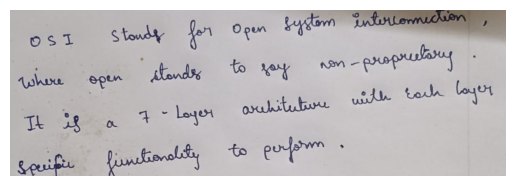

is diagram cropped properly and belong  y or n:  n


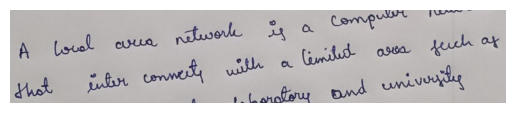

is diagram cropped properly and belong  y or n:  n


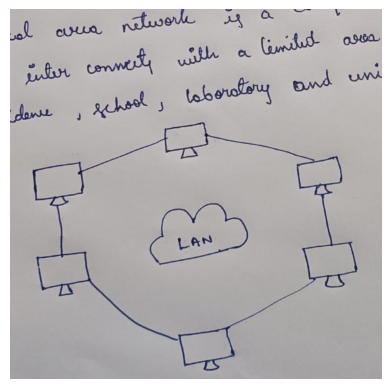

is diagram cropped properly and belong  y or n:  n


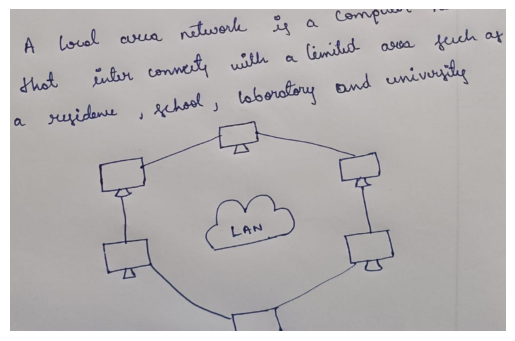

is diagram cropped properly and belong  y or n:  n


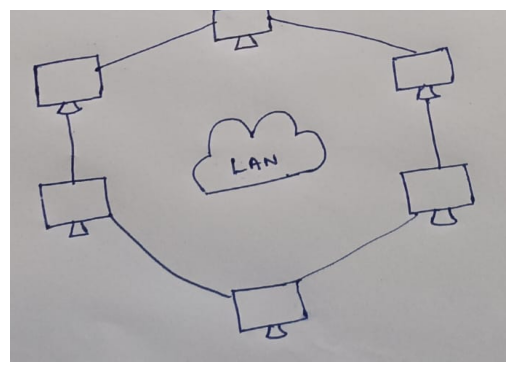

is diagram cropped properly and belong  y or n:  y


313,1028,995,1512


C:\Users\91866\AppData\Local\Temp\ipykernel_12636\1777917406.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'answer_papers/student2/diagram/ans_paper1_cropped_1.jpg|' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  student_ans_csv.iloc[row_index[0], 6] = str(prev_data)


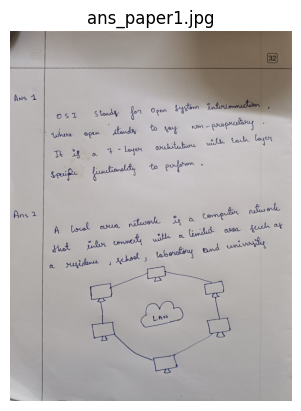


image 1/1 D:\myapps\jupyter\Project\answer_papers\student2\ans_paper2.jpg: 640x512 1 diagram, 2157.3ms
Speed: 4.8ms preprocess, 2157.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)


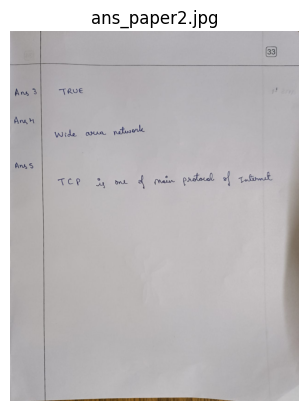

All images have been processed.


In [111]:
extract_diagram(folder)

<h1>Evaluation of answer Script and generation of csv file consisting of marks obtained</h1>

In [124]:
evaluation(folder,segmented_answers)

answer length check  0.36
0.3
0.12000000000000002
marks obtained for        3    is    1
**************************************
answer length check  0.36
0.3
0.45
marks obtained for        3    is    1
Match Score: 58.46236559139785
['lan'] ['lan']
score_for_label 10 10
**************************************
marks obtained for        1    is    1
**************************************
marks obtained for        1    is    1
**************************************
marks obtained for        1    is    1
**************************************
['1', 'Discriptive', 3, 0, 0.3, 0.36, 0.12000000000000002, 0, 1]
['2', 'Discriptive', 5, 1, 0.3, 0.36, 0.45, 2, 3]
['3', 'ToF', 1, 0, 0, 0, 0, 0, 1]
['4', 'Short', 1, 0, 0, 0, 0, 0, 1]
['5', 'Short', 1, 0, 0, 0, 0, 0, 1]
CSV file has been generated.


In [ ]:
!pip uninstall torch
!pip install torch

In [ ]:
A local area network (LAN) is a collection of devices connected together in one physical location, such as a building, office, or home